In [1]:
import os

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

import egoviz.models.processing as pr
import egoviz.models.evaluation as ev

SEED = 42

In [2]:
# if df pkl exists, load it
cwd = os.getcwd()

try:
    file_path = os.path.join(cwd, '../data/home_data_all_preds_df.pkl')
    df = pr.load_pickle(file_path)

except FileNotFoundError:
    file_path = os.path.join(cwd, '../data/home_data_all_preds.pkl')
    data = pr.load_pickle(file_path)
    df = pd.DataFrame(columns=['video', 'frame', 'classes', 'active', 'adl'])

    for id, dets in data.items():
        adl = id.split('_', 1)[0]
        video = id.split('_')[1]
        frame = id.split('_')[2]
        classes = dets['remapped_metadata']
        active = dets['active_objects']

        row = {'video': video, 'frame': frame, 'classes': classes, 'adl': adl, 'active': active}

        df.loc[len(df)] = row

    # save df
    df.to_pickle(os.path.join(cwd, '../data/home_data_eval_all_preds_df.pkl'))

In [3]:
df_active = pr.generate_counts_df(df); df_active.head()

,video,adl,count_clothing_accessory,count_phone_tablet,count_other,count_office_stationary,count_footwear,count_furniture,active_other,active_office_stationary,...,count_house_fixtures,active_house_fixtures,count_tableware,active_tableware,count_bathroom_fixture,active_bathroom_fixture,count_plant,active_plant,count_hat,active_hat
0,SCI02-1--1,functional-mobility,0.0,6.0,7.0,13.0,3.0,10.0,0.0,0.0,...,20.0,0.0,6.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,SCI02-1--10,meal-preparation-cleanup,2.0,0.0,6.0,2.0,1.0,2.0,0.0,0.0,...,17.0,0.0,18.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0
2,SCI02-1--11,meal-preparation-cleanup,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,17.0,0.0,25.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
3,SCI02-1--12,meal-preparation-cleanup,0.0,0.0,8.0,3.0,0.0,4.0,0.0,0.0,...,15.0,0.0,21.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0
4,SCI02-1--2,meal-preparation-cleanup,10.0,4.0,6.0,2.0,1.0,2.0,0.0,0.0,...,35.0,1.0,8.0,0.0,11.0,0.0,3.0,0.0,0.0,0.0


In [4]:
df_no_active = df_active.drop(columns=[col for col in df_active.columns if 'active' in col]); df_no_active.head()

,video,adl,count_clothing_accessory,count_phone_tablet,count_other,count_office_stationary,count_footwear,count_furniture,count_furnishing,count_drinkware,...,count_musical_instrument,count_sink,count_cabinetry,count_kitchen_appliance,count_tv_computer,count_house_fixtures,count_tableware,count_bathroom_fixture,count_plant,count_hat
0,SCI02-1--1,functional-mobility,0.0,6.0,7.0,13.0,3.0,10.0,8.0,19.0,...,0.0,6.0,15.0,7.0,0.0,20.0,6.0,4.0,0.0,0.0
1,SCI02-1--10,meal-preparation-cleanup,2.0,0.0,6.0,2.0,1.0,2.0,3.0,18.0,...,0.0,15.0,1.0,3.0,0.0,17.0,18.0,6.0,0.0,0.0
2,SCI02-1--11,meal-preparation-cleanup,1.0,0.0,2.0,0.0,0.0,0.0,1.0,7.0,...,0.0,18.0,0.0,0.0,0.0,17.0,25.0,13.0,0.0,0.0
3,SCI02-1--12,meal-preparation-cleanup,0.0,0.0,8.0,3.0,0.0,4.0,2.0,28.0,...,0.0,14.0,10.0,2.0,0.0,15.0,21.0,7.0,1.0,0.0
4,SCI02-1--2,meal-preparation-cleanup,10.0,4.0,6.0,2.0,1.0,2.0,1.0,47.0,...,0.0,13.0,19.0,11.0,0.0,35.0,8.0,11.0,3.0,0.0


## Classifiers

In [5]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=500, random_state=SEED)

# Logistic Regression
log_clf = LogisticRegression(random_state=SEED)

## With Active Objects

2023-11-29 11:05:35,134 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI02
2023-11-29 11:05:38,087 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI03
2023-11-29 11:05:41,025 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI06
2023-11-29 11:05:43,992 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI08
2023-11-29 11:05:46,818 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI10
2023-11-29 11:05:49,723 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI11
2023-11-29 11:05:52,432 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI12
2023-11-29 11:05:55,280 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI13
2023-11-29 11:05:58,131 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI14
2023-11-29 11:06:01,098 - ro

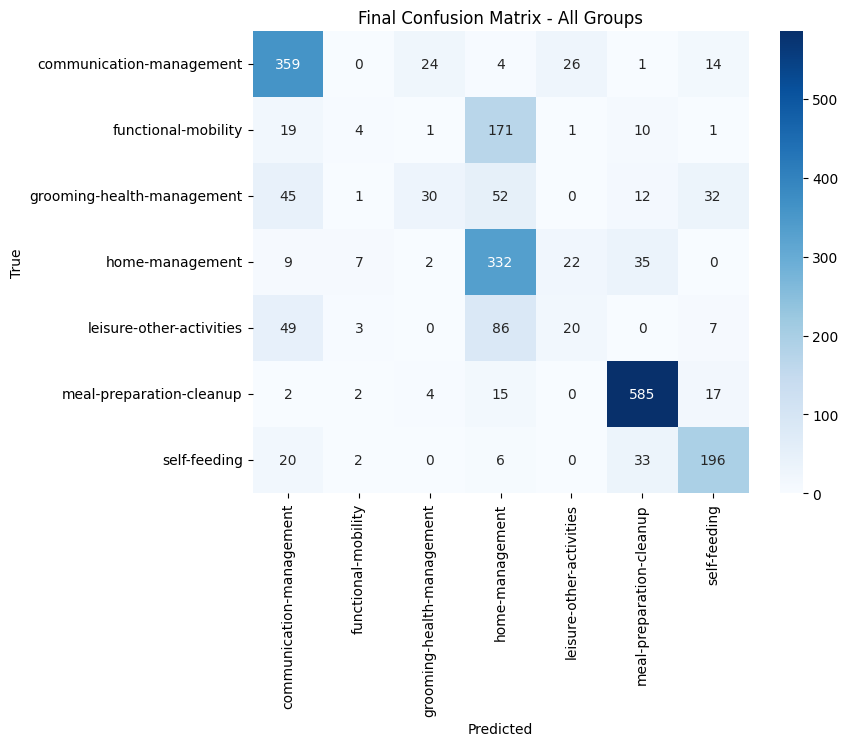

2023-11-29 11:06:18,611 - root - INFO - LOGOCV complete for RandomForestClassifier
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-29 11:06:18,740 - root - INFO - Training complete for LogisticRegression, group left out: SCI02
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

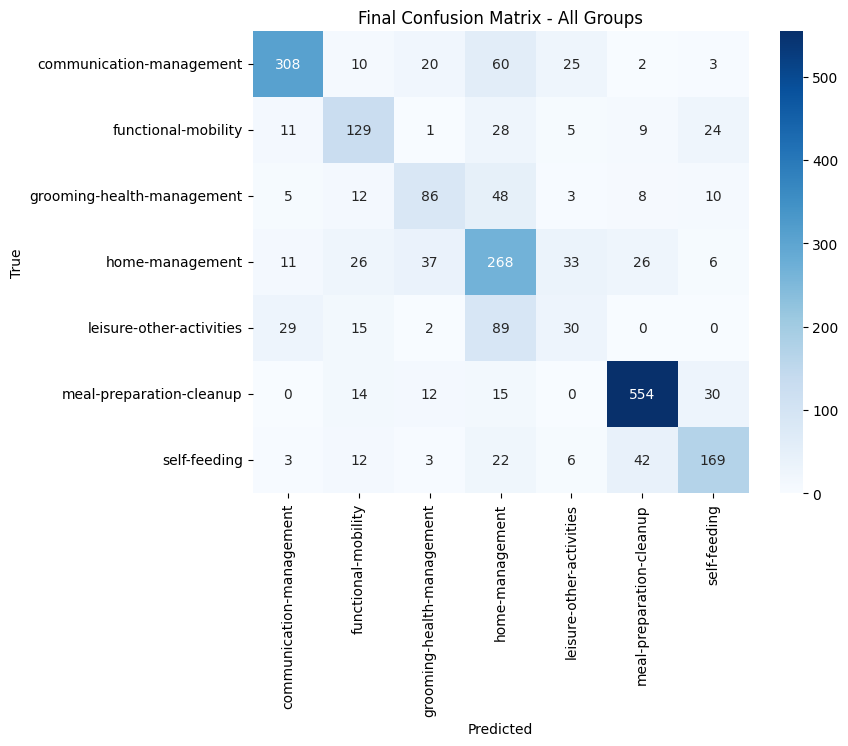

2023-11-29 11:06:21,028 - root - INFO - LOGOCV complete for LogisticRegression


In [6]:
X = df_active.drop(['adl', 'video'], axis=1)
y = df_active['adl']
groups = df_active['video'].str[:5]

# try all classifiers
rf_active = ev.leave_one_group_out_cv(df_active, X, y, groups, rf_clf)
log_active = ev.leave_one_group_out_cv(df_active, X, y, groups, log_clf)

In [7]:
# print results for each classifier
print('Random Forest Classifier')
rf_active


Random Forest Classifier


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.885417,0.863214,0.403509,0.425655,0.680399,0.631307,0.61195,0.465192
1,SCI03,0.765625,0.707090,0.561920,0.326276,0.680399,0.631307,0.61195,0.465192
2,SCI06,0.640777,0.393374,0.437013,0.817825,0.680399,0.631307,0.61195,0.465192
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.680399,0.631307,0.61195,0.465192
4,SCI10,0.183486,0.468750,0.653680,0.152799,0.680399,0.631307,0.61195,0.465192
5,SCI11,0.762626,0.687759,0.400190,0.400358,0.680399,0.631307,0.61195,0.465192
6,SCI12,0.731818,0.494721,0.592795,0.654128,0.680399,0.631307,0.61195,0.465192
7,SCI13,0.689266,0.548109,0.681822,0.363876,0.680399,0.631307,0.61195,0.465192
8,SCI14,0.684783,0.668346,0.568661,0.447750,0.680399,0.631307,0.61195,0.465192
9,SCI15,0.911765,0.955926,0.647483,0.671892,0.680399,0.631307,0.61195,0.465192


In [8]:
print('Logistic Regression')
log_active

Logistic Regression


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.947917,0.908730,0.530516,0.519138,0.697566,0.531792,0.657786,0.526519
1,SCI03,0.796875,0.572523,0.677488,0.503732,0.697566,0.531792,0.657786,0.526519
2,SCI06,0.621359,0.665816,0.291775,0.587685,0.697566,0.531792,0.657786,0.526519
3,SCI08,0.571429,0.600000,0.666667,0.296296,0.697566,0.531792,0.657786,0.526519
4,SCI10,0.669725,0.380092,0.778531,0.286616,0.697566,0.531792,0.657786,0.526519
5,SCI11,0.772727,0.359084,0.579180,0.656400,0.697566,0.531792,0.657786,0.526519
6,SCI12,0.640909,0.535229,0.615291,0.531548,0.697566,0.531792,0.657786,0.526519
7,SCI13,0.451977,0.402810,0.630814,0.367653,0.697566,0.531792,0.657786,0.526519
8,SCI14,0.722826,0.566936,0.651202,0.674388,0.697566,0.531792,0.657786,0.526519
9,SCI15,0.876471,0.581679,0.707087,0.732821,0.697566,0.531792,0.657786,0.526519


### Trying XGBoost

In [9]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

2023-11-29 11:06:22,156 - root - INFO - Training complete for XGBClassifier, group left out: SCI02
2023-11-29 11:06:22,883 - root - INFO - Training complete for XGBClassifier, group left out: SCI03
2023-11-29 11:06:23,551 - root - INFO - Training complete for XGBClassifier, group left out: SCI06
2023-11-29 11:06:24,264 - root - INFO - Training complete for XGBClassifier, group left out: SCI08
2023-11-29 11:06:25,184 - root - INFO - Training complete for XGBClassifier, group left out: SCI10
2023-11-29 11:06:25,822 - root - INFO - Training complete for XGBClassifier, group left out: SCI11
2023-11-29 11:06:26,421 - root - INFO - Training complete for XGBClassifier, group left out: SCI12
2023-11-29 11:06:26,966 - root - INFO - Training complete for XGBClassifier, group left out: SCI13
2023-11-29 11:06:27,495 - root - INFO - Training complete for XGBClassifier, group left out: SCI14
2023-11-29 11:06:28,094 - root - INFO - Training complete for XGBClassifier, group left out: SCI15
2023-11-29

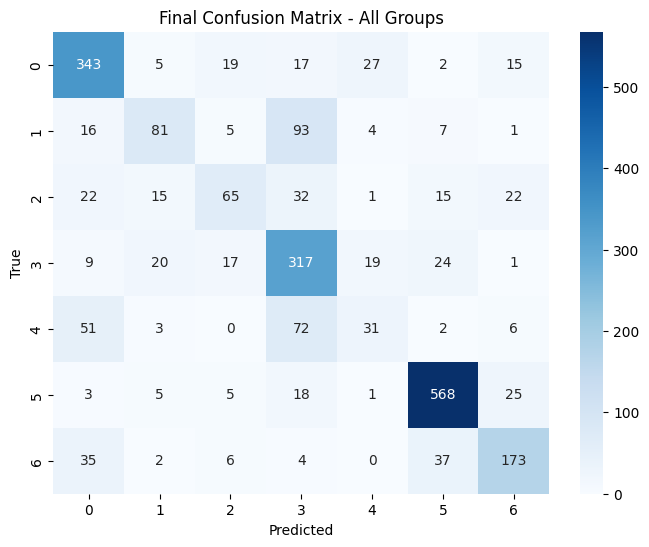

2023-11-29 11:06:31,971 - root - INFO - LOGOCV complete for XGBClassifier


XGBoost Classifier


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.916667,0.865614,0.442797,0.450728,0.698801,0.549832,0.627834,0.503456
1,SCI03,0.765625,0.508889,0.555418,0.526641,0.698801,0.549832,0.627834,0.503456
2,SCI06,0.660194,0.564613,0.450000,0.713411,0.698801,0.549832,0.627834,0.503456
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.698801,0.549832,0.627834,0.503456
4,SCI10,0.490826,0.310046,0.767473,0.235652,0.698801,0.549832,0.627834,0.503456
5,SCI11,0.742424,0.400086,0.387143,0.677617,0.698801,0.549832,0.627834,0.503456
6,SCI12,0.690909,0.490958,0.562492,0.639526,0.698801,0.549832,0.627834,0.503456
7,SCI13,0.644068,0.348294,0.701379,0.426388,0.698801,0.549832,0.627834,0.503456
8,SCI14,0.722826,0.746816,0.617838,0.496206,0.698801,0.549832,0.627834,0.503456
9,SCI15,0.864706,0.467588,0.739410,0.596929,0.698801,0.549832,0.627834,0.503456


In [10]:
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=len(set(y)), eval_metric='mlogloss', random_state=SEED)
xgb_active = ev.leave_one_group_out_cv(df_active, X, y_encoded, groups, xgb_clf, xgb=True)
print('XGBoost Classifier')
xgb_active

## Without Active Objects

2023-11-29 11:06:34,862 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI02
2023-11-29 11:06:37,893 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI03
2023-11-29 11:06:40,796 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI06
2023-11-29 11:06:43,795 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI08
2023-11-29 11:06:46,831 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI10
2023-11-29 11:06:49,809 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI11
2023-11-29 11:06:52,504 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI12
2023-11-29 11:06:55,319 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI13
2023-11-29 11:06:58,233 - root - INFO - Training complete for RandomForestClassifier, group left out: SCI14
2023-11-29 11:07:00,972 - ro

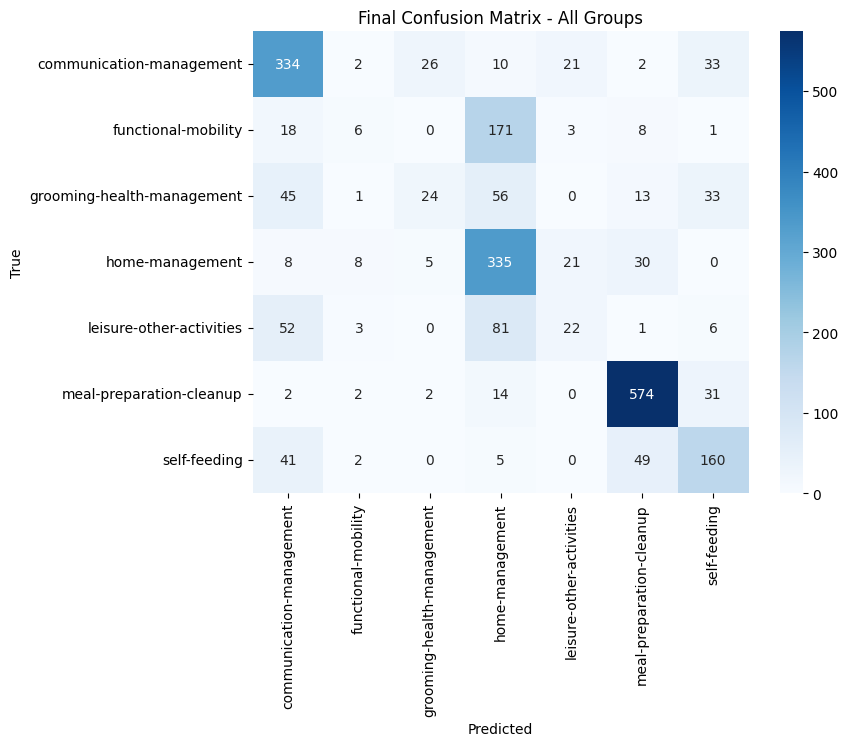

2023-11-29 11:07:18,038 - root - INFO - LOGOCV complete for RandomForestClassifier
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023-11-29 11:07:18,124 - root - INFO - Training complete for LogisticRegression, group left out: SCI02
/Users/adeshkadambi/Documents/GitHub/EgoVizML/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

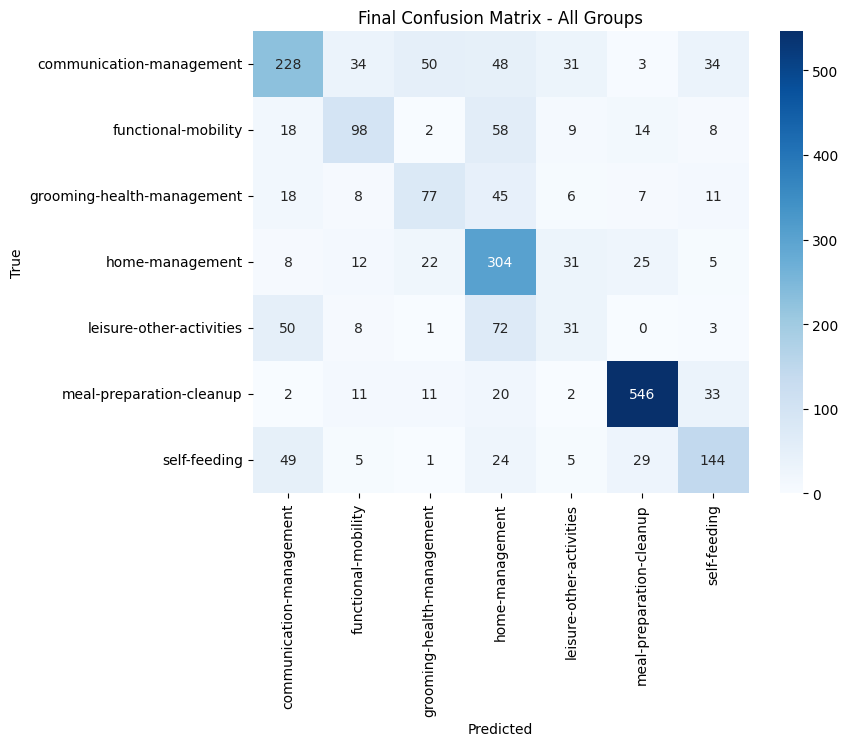

2023-11-29 11:07:20,143 - root - INFO - LOGOCV complete for LogisticRegression


In [11]:
X = df_no_active.drop(['adl', 'video'], axis=1)
y = df_no_active['adl']
groups = df_no_active['video'].str[:5]

# try all classifiers
rf = ev.leave_one_group_out_cv(df_no_active, X, y, groups, rf_clf)
log = ev.leave_one_group_out_cv(df_no_active, X, y, groups, log_clf)

In [12]:
# print results for each classifier
print('Random Forest Classifier')
rf

Random Forest Classifier


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.864583,0.856504,0.382456,0.407556,0.653633,0.597967,0.576903,0.488539
1,SCI03,0.781250,0.711966,0.567183,0.332621,0.653633,0.597967,0.576903,0.488539
2,SCI06,0.611650,0.318805,0.256061,0.768366,0.653633,0.597967,0.576903,0.488539
3,SCI08,0.571429,0.666667,0.666667,0.333333,0.653633,0.597967,0.576903,0.488539
4,SCI10,0.165138,0.401361,0.687899,0.124753,0.653633,0.597967,0.576903,0.488539
5,SCI11,0.717172,0.694306,0.358825,0.372689,0.653633,0.597967,0.576903,0.488539
6,SCI12,0.718182,0.444558,0.531231,0.750156,0.653633,0.597967,0.576903,0.488539
7,SCI13,0.666667,0.552288,0.649264,0.340533,0.653633,0.597967,0.576903,0.488539
8,SCI14,0.521739,0.477771,0.473182,0.514716,0.653633,0.597967,0.576903,0.488539
9,SCI15,0.888235,0.686063,0.607588,0.887887,0.653633,0.597967,0.576903,0.488539


In [13]:
print('Logistic Regression')
log

Logistic Regression


,group_left_out,accuracy,precision,recall,f1,mean_accuracy,mean_precision,mean_recall,mean_f1
0,SCI02,0.958333,0.917854,0.533333,0.525427,0.644485,0.52051,0.609412,0.458795
1,SCI03,0.812500,0.589474,0.682751,0.510175,0.644485,0.52051,0.609412,0.458795
2,SCI06,0.514563,0.515723,0.174242,0.501116,0.644485,0.52051,0.609412,0.458795
3,SCI08,0.571429,0.500000,0.750000,0.250000,0.644485,0.52051,0.609412,0.458795
4,SCI10,0.568807,0.321856,0.791325,0.239554,0.644485,0.52051,0.609412,0.458795
5,SCI11,0.691919,0.446580,0.523079,0.615698,0.644485,0.52051,0.609412,0.458795
6,SCI12,0.609091,0.440718,0.479716,0.424693,0.644485,0.52051,0.609412,0.458795
7,SCI13,0.412429,0.489759,0.610349,0.181849,0.644485,0.52051,0.609412,0.458795
8,SCI14,0.516304,0.378739,0.527289,0.502420,0.644485,0.52051,0.609412,0.458795
9,SCI15,0.882353,0.571607,0.688905,0.723080,0.644485,0.52051,0.609412,0.458795
